<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Precipitation Accumulation Region of Interest
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/precip_roi_preview.png" alt="Colorized Precipation Accumulation with Identified Region of Interest" style="height: 300px;"></div>


# Objectives

* Access the model data from an EDEX server and limit the data returned by using model specific parameters
* Calculate the total precipitation over several model runs
* Create a colorized plot for the continental US of the accumulated precipitation data
* Calculate and identify area of highest of precipitation
* Use higher resolution data to draw region of interest

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Setup</a></span><ul class="toc-item"><li><span><a href="#Geographic-Filter" data-toc-modified-id="Geographic-Filter-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Geographic Filter</a></span></li><li><span><a href="#EDEX-Connection" data-toc-modified-id="EDEX-Connection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EDEX Connection</a></span></li><li><span><a href="#Refine-the-Request" data-toc-modified-id="Refine-the-Request-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Refine the Request</a></span></li><li><span><a href="#Get-Times" data-toc-modified-id="Get-Times-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Get Times</a></span></li></ul></li><li><span><a href="#Function:-calculate_accumulated_precip()" data-toc-modified-id="Function:-calculate_accumulated_precip()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function: calculate_accumulated_precip()</a></span></li><li><span><a href="#Fuction:-make_map()" data-toc-modified-id="Fuction:-make_map()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fuction: make_map()</a></span></li><li><span><a href="#Get-the-Data!" data-toc-modified-id="Get-the-Data!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get the Data!</a></span></li><li><span><a href="#Plot-the-Data!" data-toc-modified-id="Plot-the-Data!-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the Data!</a></span><ul class="toc-item"><li><span><a href="#Create-CONUS-Image" data-toc-modified-id="Create-CONUS-Image-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create CONUS Image</a></span></li><li><span><a href="#Create-Region-of-Interest-Image" data-toc-modified-id="Create-Region-of-Interest-Image-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create Region of Interest Image</a></span></li></ul></li><li><span><a href="#High-Resolution-ROI" data-toc-modified-id="High-Resolution-ROI-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>High Resolution ROI</a></span><ul class="toc-item"><li><span><a href="#New-Data-Request" data-toc-modified-id="New-Data-Request-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>New Data Request</a></span></li><li><span><a href="#Calculate-Data" data-toc-modified-id="Calculate-Data-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Calculate Data</a></span></li><li><span><a href="#Plot-ROI" data-toc-modified-id="Plot-ROI-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Plot ROI</a></span></li></ul></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook. Note the first import is coming directly from python-awips and allows us to connect to an EDEX server. The subsequent imports are for data manipulation and visualization.

In [1]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
from shapely.geometry import Point, Polygon

<a href="#top">Top</a>

---

## Initial Setup

### Geographic Filter

By defining a bounding box for the Continental US (CONUS), we’re able to optimize the data request sent to the EDEX server.

In [2]:
conus=[-125, -65, 25, 55]
conus_envelope = Polygon([(conus[0],conus[2]),(conus[0],conus[3]),
                          (conus[1],conus[3]),(conus[1],conus[2]),
                          (conus[0],conus[2])])

### EDEX Connection

First we establish a connection to Unidata’s public EDEX server. With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to **grid**, and use the geographic envelope we just created.

In [3]:
DataAccessLayer.changeEDEXHost("edex-beta.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("grid", envelope=conus_envelope)

### Refine the Request

Here we specify which model we're interested in by setting the *LocationNames*, and the specific data we're interested in by setting the *Levels* and *Parameters*.

In [4]:
request.setLocationNames("GFS1p0")
request.setLevels("0.0SFC")
request.setParameters("TP")

### Get Times

We need to get the available times and cycles for our model data

In [5]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

<a href="#top">Top</a>

---

## Function: calculate_accumulated_precip()

Since we'll want to calculate the accumulated precipitation of our data more than once, it makes sense to create a function that we can call instead of duplicating the logic.

This function cycles through all the grid data responses and adds up all of the rainfall to produce a numpy array with the total ammount of rainfall for the given data request.  It also finds the maximum rainfall point in x and y coordinates.

In [6]:
def calculate_accumulated_precip(dataRequest, forecastRun):

    for i, tt in enumerate(forecastRun):
        response = DataAccessLayer.getGridData(dataRequest, [tt])
        grid = response[0]
        if i>0:
            data += grid.getRawData()
        else:
            data = grid.getRawData()
        data[data <= -9999] = 0
        print(data.min(), data.max(), grid.getDataTime().getFcstTime()/3600)

    # Convert from mm to inches
    result = (data * units.mm).to(units.inch)
    
    ii,jj = np.where(result==result.max())
    i=ii[0]
    j=jj[0]

    return result, i, j

<a href="#top">Top</a>

---

## Fuction: make_map()

This function creates the basics of the map we're going to plot our data on. It takes in a bounding box to determine the extent and then adds coastlines for easy frame of reference.

In [7]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20, 14),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    return fig, ax

<a href="#top">Top</a>

---

## Get the Data!

Access the data from the DataAccessLayer interface using the *getGridData* function.  Use that data to calculate the accumulated rainfall, the maximum rainfall point, and the region of interest bounding box.

In [8]:
## get the grid response from edex
response = DataAccessLayer.getGridData(request, [fcstRun[-1]])    
## take the first result to get the location information from
grid = response[0]

## get the location coordinates and create a bounding box for our map
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
fcstHr = int(grid.getDataTime().getFcstTime()/3600)

## calculate the total precipitation
tp_inch, i, j = calculate_accumulated_precip(request, fcstRun)
print(tp_inch.min(), tp_inch.max())

## use the max points coordinates to get the max point in lat/lon coords
maxPoint = Point(lons[i][j], lats[i][j])
inc = 3.5
## create a region of interest bounding box
roi_box=[maxPoint.x-inc, maxPoint.x+inc, maxPoint.y-inc, maxPoint.y+inc]
roi_polygon = Polygon([(roi_box[0],roi_box[2]),(roi_box[0],roi_box[3]), 
                (roi_box[1],roi_box[3]),(roi_box[1],roi_box[2]),(roi_box[0],roi_box[2])])

print(maxPoint)

0.0 18.75 6.0
0.0 24.5625 12.0
0.0 40.875 18.0
0.0 65.125 24.0
0.0 76.9375 30.0
0.0 80.3125 36.0
0.0 80.3125 42.0
0.0 80.3125 48.0
0.0 80.3125 54.0
0.0 80.3125 60.0
0.0 80.9375 66.0
0.0 84.375 72.0
0.0 92.0 78.0
0.0 95.5 84.0
0.0 95.75 90.0
0.0 96.3125 96.0
0.0 96.375 102.0
0.0 96.375 108.0
0.0 96.4375 114.0
0.0 96.625 120.0
0.0 96.625 126.0
0.0 96.625 132.0
0.0 97.4375 138.0
0.0 102.625 144.0
0.0 104.4375 150.0
0.0 109.25 156.0
0.0 109.625 162.0
0.0 113.25 168.0
0.0 127.625 174.0
0.0 142.8125 180.0
0.0 156.1875 186.0
0.0 156.25 192.0
0.0 156.75 198.0
0.0 157.1875 204.0
0.0 157.1875 210.0
0.0 157.1875 216.0
0.0 157.25 222.0
0.0 161.4375 228.0
0.0 164.6875 234.0
0.0 165.0 240.0
0.0 inch 6.496062755584717 inch
POINT (-84 35)


<a href="#top">Top</a>

---

## Plot the Data!

### Create CONUS Image

Plot our data on our CONUS map.

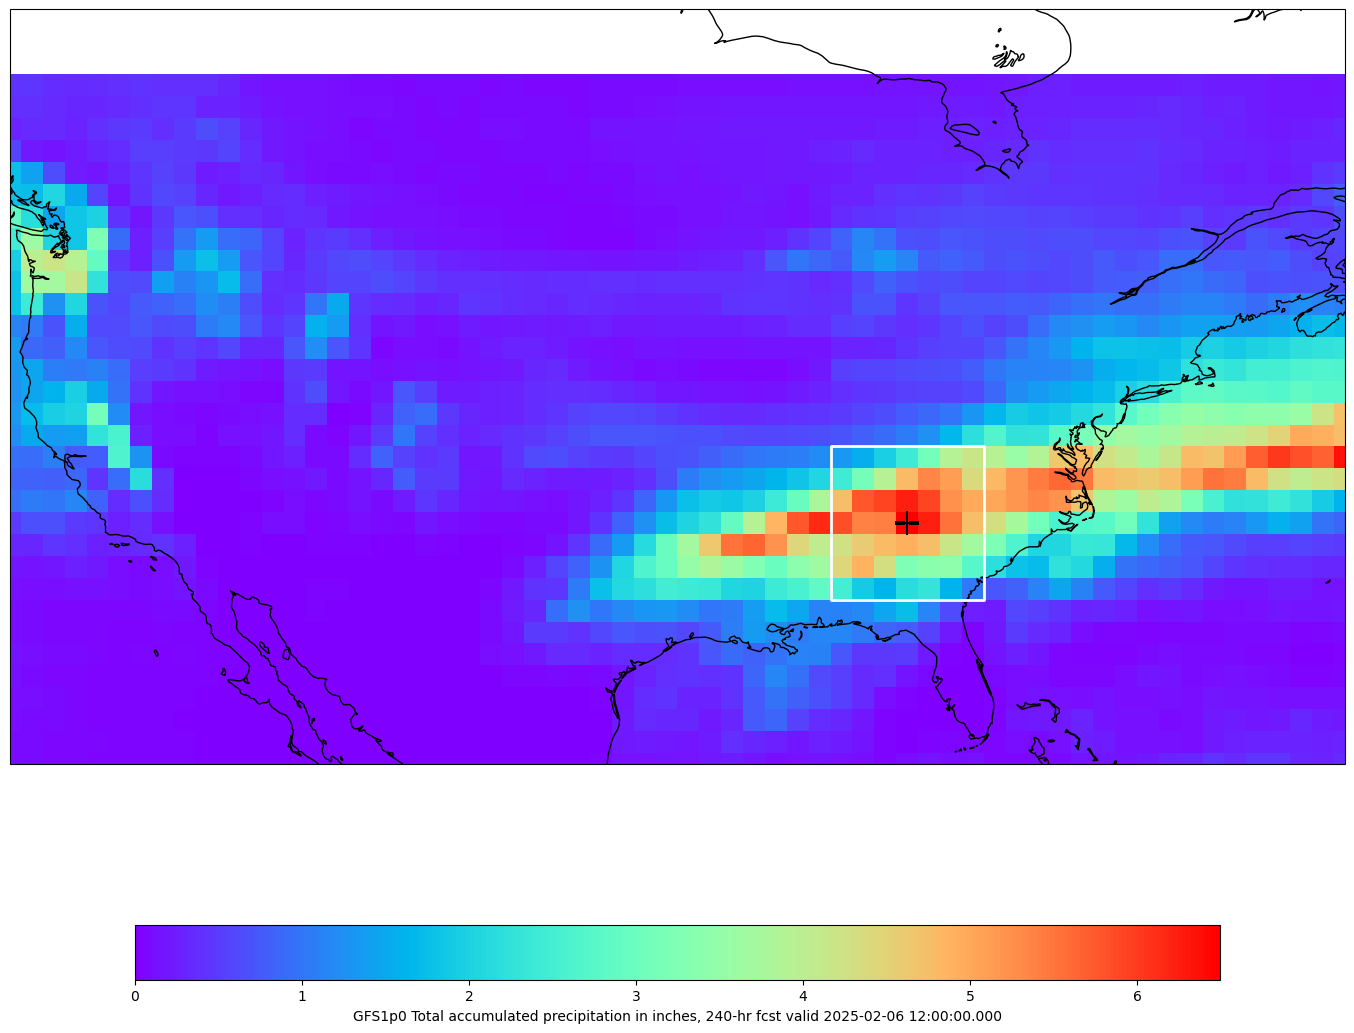

In [9]:
cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(lons, lats, tp_inch, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(fcstHr) + "-hr fcst valid " + str(grid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

ax.add_geometries([roi_polygon], ccrs.PlateCarree(), facecolor='none', edgecolor='white', linewidth=2)

### Create Region of Interest Image

Now crop the data and zoom in on the region of interest (ROI) to create a new plot.

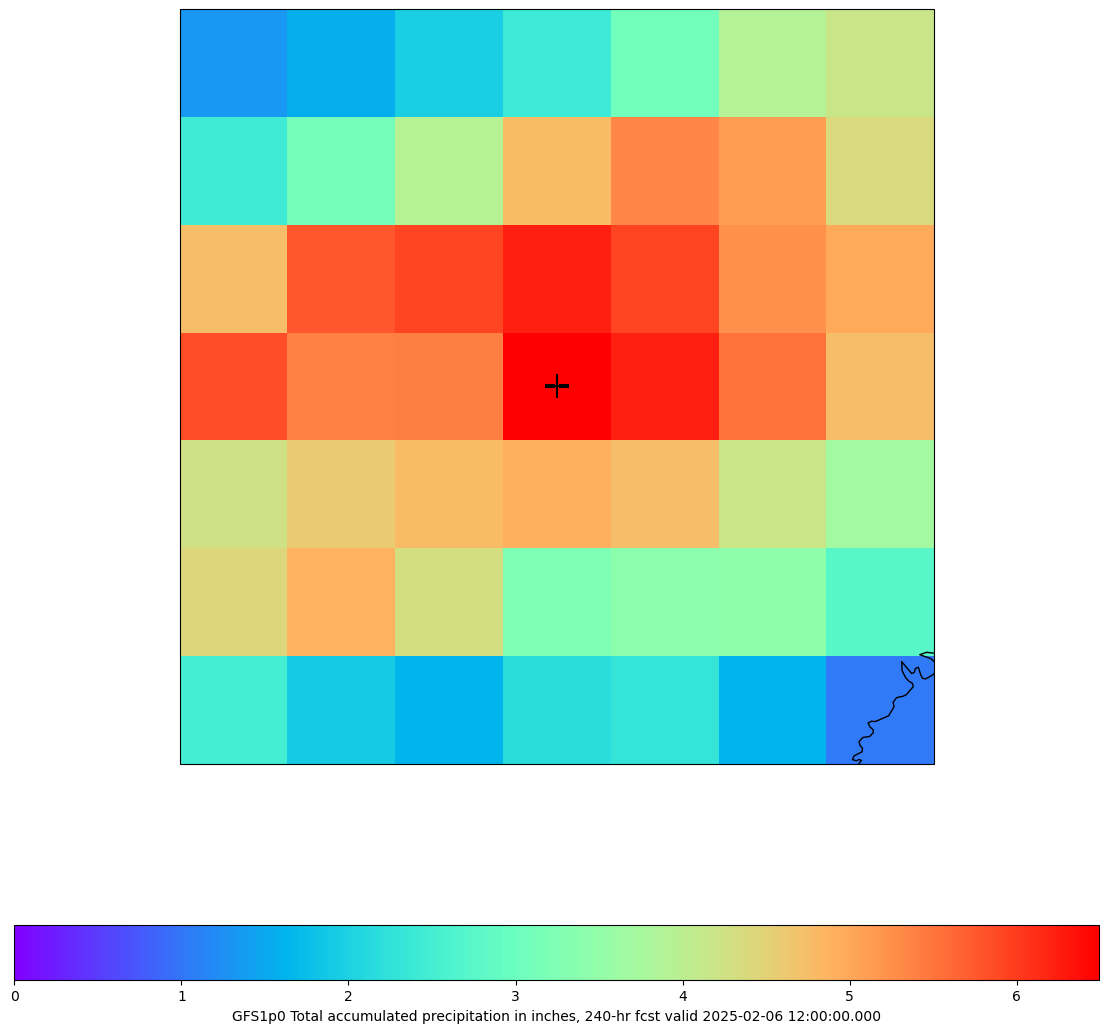

In [10]:
# cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=roi_box)

cs = ax.pcolormesh(lons, lats, tp_inch, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(fcstHr) + "-hr fcst valid " + str(grid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

<a href="#top">Top</a>

---

## High Resolution ROI

### New Data Request

To see the region of interest more clearly, we can redo the process with a higher resolution model (GFS20 vs. GFS1.0).

In [11]:
roiRequest = DataAccessLayer.newDataRequest("grid", envelope=conus_envelope)
roiRequest.setLocationNames("GFS20")
roiRequest.setLevels("0.0SFC")
roiRequest.setParameters("TP")

roiCycles = DataAccessLayer.getAvailableTimes(roiRequest, True)
roiTimes = DataAccessLayer.getAvailableTimes(roiRequest)
roiFcstRun = DataAccessLayer.getForecastRun(roiCycles[-1], roiTimes)

### Calculate Data

In [12]:
roiResponse = DataAccessLayer.getGridData(roiRequest, [roiFcstRun[-1]])  
print(roiResponse)
roiGrid = roiResponse[0]

roiLons, roiLats = roiGrid.getLatLonCoords()

roi_data, i, j = calculate_accumulated_precip(roiRequest, roiFcstRun)

roiFcstHr = int(roiGrid.getDataTime().getFcstTime()/3600)

0.0 20.5625 3.0
0.0 28.8125 6.0
0.0 32.0625 9.0
0.0 32.25 12.0
0.0 42.125 15.0
0.0 52.8125 18.0
0.0 77.625 21.0
0.0 116.8125 24.0
0.0 143.5 27.0
0.0 157.8125 30.0
0.0 175.25 33.0
0.0 177.1875 36.0
0.0 177.1875 39.0
0.0 177.1875 42.0
0.0 177.1875 45.0
0.0 177.1875 48.0
0.0 177.1875 51.0
0.0 177.1875 54.0
0.0 177.1875 57.0
0.0 177.1875 60.0
0.0 177.1875 63.0
0.0 177.1875 66.0
0.0 177.8125 69.0
0.0 178.1875 72.0
0.0 178.375 75.0
0.0 178.6875 78.0
0.0 188.375 81.0
0.0 188.5 84.0
0.0 188.6875 90.0
0.0 189.1875 96.0
0.0 189.375 102.0
0.0 189.4375 108.0
0.0 189.4375 114.0
0.0 189.75 120.0
0.0 189.75 126.0
0.0 189.75 132.0
0.0 189.9375 138.0
0.0 191.125 144.0
0.0 191.9375 150.0
0.0 196.375 156.0
0.0 196.75 162.0
0.0 196.75 168.0
0.0 196.8125 174.0
0.0 197.625 180.0
0.0 197.75 186.0
0.0 198.1875 192.0
0.0 199.75 198.0
0.0 208.375 204.0
0.0 211.125 210.0
0.0 211.375 216.0
0.0 211.375 222.0
0.0 211.4375 228.0
0.0 211.625 234.0
0.0 236.875 240.0


### Plot ROI

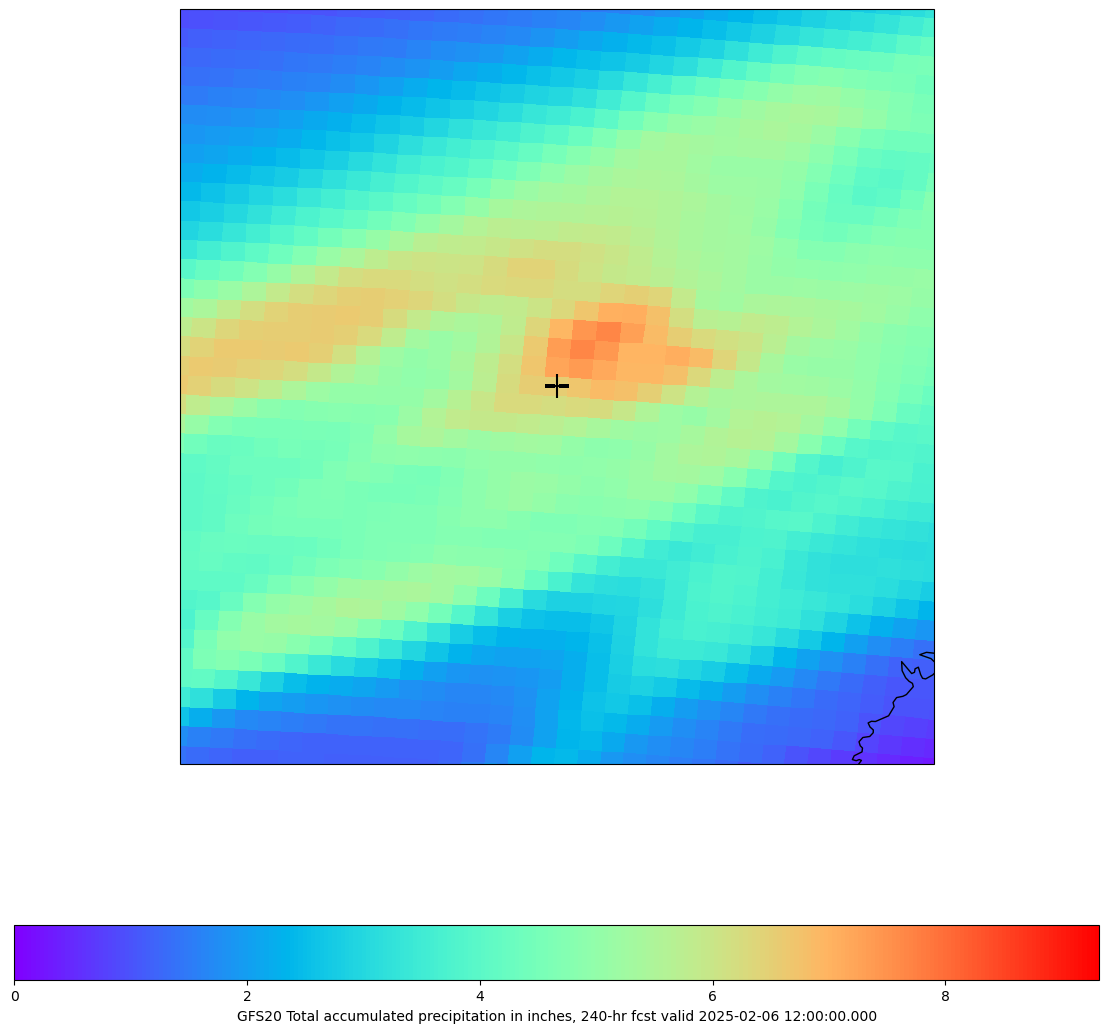

In [13]:
# cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=roi_box)

cs = ax.pcolormesh(roiLons, roiLats, roi_data, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(roiGrid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(roiFcstHr) + "-hr fcst valid " + str(roiGrid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

<a href="#top">Top</a>

---

## See Also

### Related Notebooks

* [Colorized Grid Data](https://unidata.github.io/python-awips/examples/generated/Colorized_Grid_Data.html)
* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)

### Additional Documentation

**python-awips:**
* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.PyGridData](http://unidata.github.io/python-awips/api/PyGridData.html)

**matplotlib:**
* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)
* [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html)
* [matplotlib.pyplot.pcolormesh](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.pcolormesh.html)

<a href="#top">Top</a>

---